In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
import pickle
file_x = open('./dataverse_files/pristine_dataset_x.pkl', 'rb')
file_y = open('./dataverse_files/pristine_dataset_y.pkl', 'rb')
X = pickle.load(file_x, encoding='bytes')
print(X.shape)
Y = pickle.load(file_y, encoding='bytes')
print(Y.shape)
print(X.shape[0])
idx = np.random.permutation(X.shape[0])
X = X[idx]
Y = Y[idx]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 3))
Y = Y.reshape((Y.shape[0], 1))

(10517, 64, 64, 3)
(10517,)
10517


In [70]:
X_train = X[:7500]
Y_train = Y[:7500]

X_test = X[7500:]
Y_test = Y[7500:]

In [71]:
classes = (
    "bcc", 
    "bct_139", 
    "bct_141", 
    "diam", 
    "fcc", 
    "hex/rh", 
    "sc"
)

In [72]:
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms

class FingerprintDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.samples[0][index]
        y = self.samples[1][index]
        
        if self.transform:
            x = self.transform(np.uint8(x*255.0))
        
        return x, torch.tensor(y)
    
    def __len__(self):
        return self.samples[0].shape[0]

In [73]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = FingerprintDataset((X_train, Y_train), transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = FingerprintDataset((X_test, Y_test), transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

torch.Size([32, 3, 64, 64])


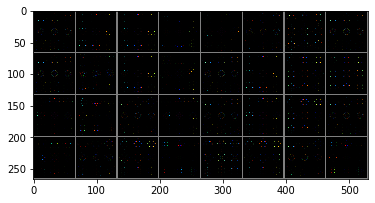

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images, nrow=8))

# for i in range (32):
#     print(labels[i])

In [75]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, input_size=(3, 64, 64)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (7, 7), padding=(3, 3)), # padding = (F-1)/2 (to keep the size constant) 
            nn.ReLU(),
            nn.Conv2d(32, 32, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)), # 32
            nn.Conv2d(32, 16, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 16, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)), # 16
            nn.Conv2d(16, 8, (7, 7), padding=(3, 3)),
            nn.ReLU(),
            nn.Conv2d(8, 8, (7, 7), padding=(3, 3)),
            nn.ReLU(),
        )
        
        self.flat_fts = self.get_flat_fts(input_size, self.features)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_fts, 128),
            nn.Dropout(p=0.25),
            nn.BatchNorm1d(128),
            nn.Linear(128, 7),
            nn.Softmax(dim=1)
        )
        
    def get_flat_fts(self, in_size, fts):
        f = fts(Variable(torch.ones(1,*in_size)))
        return int(np.prod(f.size()[1:]))
    
    def forward(self, x):
        fts = self.features(x)
        flat_fts = fts.view(-1, self.flat_fts)
        out = self.classifier(flat_fts)
        return out

In [76]:
net = Net()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): ReLU()
    (12): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (13): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=128, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): L

In [77]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [78]:
def train(trainloader, numEpochs):
    
    for epoch in range(numEpochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            labels = labels.squeeze_()
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # print(inputs.shape)
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0

    print('Finished Training')

In [79]:
train(train_loader, 10)

[1,    10] loss: 1.943
[1,    20] loss: 1.939
[1,    30] loss: 1.918
[1,    40] loss: 1.744
[1,    50] loss: 1.486
[1,    60] loss: 1.420
[1,    70] loss: 1.357
[1,    80] loss: 1.369
[1,    90] loss: 1.326
[1,   100] loss: 1.322
[1,   110] loss: 1.267
[1,   120] loss: 1.247
[1,   130] loss: 1.221
[1,   140] loss: 1.225
[1,   150] loss: 1.209
[1,   160] loss: 1.218
[1,   170] loss: 1.232
[1,   180] loss: 1.224
[1,   190] loss: 1.192
[1,   200] loss: 1.196
[1,   210] loss: 1.204
[1,   220] loss: 1.205
[1,   230] loss: 1.192
[2,    10] loss: 1.191
[2,    20] loss: 1.175
[2,    30] loss: 1.180
[2,    40] loss: 1.177
[2,    50] loss: 1.188
[2,    60] loss: 1.207
[2,    70] loss: 1.210
[2,    80] loss: 1.195
[2,    90] loss: 1.187
[2,   100] loss: 1.174
[2,   110] loss: 1.178
[2,   120] loss: 1.182
[2,   130] loss: 1.176
[2,   140] loss: 1.197
[2,   150] loss: 1.195
[2,   160] loss: 1.194
[2,   170] loss: 1.188
[2,   180] loss: 1.180
[2,   190] loss: 1.174
[2,   200] loss: 1.170
[2,   210] 

In [80]:
PATH = './crystalClassification_net.pth'
torch.save(net.state_dict(), PATH)

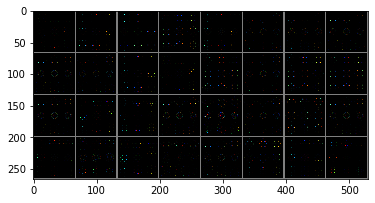

GroundTruth:  bct_141   bcc   bcc   fcc   bcc hex/rh hex/rh hex/rh hex/rh hex/rh   bcc bct_141   fcc hex/rh   fcc   fcc hex/rh bct_141  diam hex/rh hex/rh hex/rh   fcc hex/rh   bcc hex/rh bct_141 hex/rh hex/rh   fcc   bcc  diam


In [81]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [82]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [83]:
outputs = net(images)

In [84]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

Predicted:  bct_141   bcc   bcc   fcc   bcc hex/rh hex/rh hex/rh hex/rh hex/rh   bcc bct_141   fcc hex/rh   fcc   fcc hex/rh bct_141  diam hex/rh hex/rh hex/rh   fcc hex/rh   bcc hex/rh bct_141 hex/rh hex/rh   fcc   bcc  diam


In [85]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        for i in range (labels.size(0)):
            correct += int((predicted[i] == labels[i][0]))

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*correct/total))

Accuracy of the network on the 10000 test images: 99 %


In [87]:
a = 2
a *= [1, 2, 3]
print (a)

[1, 2, 3, 1, 2, 3]
